In [1]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import re
import pandas as pd
import numpy as np
import string
import time
import math
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, random_split, Dataset
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [2]:
## Initialize needed variables and set up pipelines for tokenizations

train = pd.read_pickle('Preprocessing_Train.pkl')

stop_words = stopwords.words('english')
non_neg_stop = [i for i in stop_words if "n't" not in i and "no" not in i]
lemma = WordNetLemmatizer()


def pos(x):
    if x.startswith('J'):
        return 'a'
    elif x.startswith('V'):
        return 'v'
    elif x.startswith('R'):
        return 'r'
    else:
        return 'n'
    
    
def tok(doc, non_neg=False, lemmatized=False):
    
    if non_neg:
        stop = non_neg_stop
    else:
        stop = stop_words
       
    tokens = re.split(r'\s', doc.lower())
    
    if lemmatized:
        pos_list = nltk.pos_tag(tokens)
        tokens = list(map(lambda x: lemma.lemmatize(x[0], pos(x[1])), pos_list))    

    tokens = [i for i in tokens if i not in stop]
    tokens = [i for i in tokens if len(re.findall(r'\w', i)) >= 2]
    tokens = [re.findall(r"\w[a-zA-Z0-9.-]*\w", i)[0] for i in tokens if re.findall(r"\w[a-zA-Z0-9.-]*\w", i)]
    
    return tokens


def get_voc_new(X, non_neg=True, lemmatized=True):
    
    voc = []
    token_list = []
    for i in X:
        tokens = tok(i, non_neg, lemmatized)
        token_list.append(tokens)
        voc += tokens
        
    voc = list(set(voc))
    
    return voc, token_list

In [147]:
# new = pd.read_csv('new.csv')
# target = new.sort_values('word_emb_loss', ascending=False).reset_index(drop=True).label_idx[:10]
# target = torch.tensor(np.array(list(target)), dtype=torch.long)
# normal = [i for i in range(50) if i not in target]

In [3]:
target = [8, 9, 22, 35]
normal = [i for i in range(50) if i not in target]

## Label Examinations

In [4]:
## label_12 Emb 50_epochs 128_batch 3e-4_LR
## label_29 Emb 50_epochs 128_batch 3e-4_LR
## label_38 Emb 50_epochs 128_batch 3e-4_LR


# train['sp_y'] = 0
# train.loc[[i for i in range(len(train)) if 20 in train.label_idx[i]], 'sp_y'] = 1

X_train, X_test, y_train, y_test = train_test_split(train.document_text, train.label, test_size=0.25)

voc, tk_list_train = get_voc_new(X_train, False, True)
voc_test, tk_list_test = get_voc_new(X_test, False, True)
voc_dic = {item: idx+1 for idx, item in enumerate(voc)}

def word2idx(token_list):
    
    token_idx = []
    for sent in token_list:
        sent_list = []
        for token in sent:
            if token in voc_dic:
                idx = voc_dic[token]
            else:
                idx = 0
            sent_list.append(idx)
        token_idx.append(sent_list)

    return token_idx


tk_idx_train = word2idx(tk_list_train)
tk_idx_test = word2idx(tk_list_test)

### TFIDF

In [8]:
tfidf = TfidfVectorizer(vocabulary=voc)
vec_train = tfidf.fit_transform(X_train)
vec_test = tfidf.transform(X_test)

class _dataset(Dataset):
    
    def __init__(self, X, y):
        super(_dataset, self).__init__()
        self.X = torch.Tensor(X)
        self.y = torch.Tensor(y)
        
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
    def __len__(self):
        return len(self.X)
    
    
_train = _dataset(vec_train.toarray(), np.array(list(y_train))[:,target])
_test = _dataset(vec_test.toarray(), np.array(list(y_test))[:,target])

In [9]:
class MLP_model(nn.Module):
    
    def __init__(self):

        super(MLP_model, self).__init__()
        
        self.net = nn.Sequential(
            nn.Linear(vec_train.shape[1], 500),
            nn.ReLU(),
            nn.Linear(500, 4),
            nn.Sigmoid())

            
    def forward(self, x):
        return self.net(x)

In [16]:
def train_model(model, train_dataset, eval_dataset, device, norm=0.5,
                lr=0.0005, epochs=50, batch_size=256):
    
    history = {'train_loss': [], 'eval_loss': [], 'detail_train': [], 'detail_eval': []}
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    eval_loader = DataLoader(eval_dataset, batch_size=batch_size)

    model = model.to(device)
    save_loss = nn.BCELoss(reduction='none').to(device)
    
    if norm:
        Loss = nn.BCELoss(weight=train_.y.sum(axis=0)**-norm).to(device)

    else:
        Loss = nn.BCELoss().to(device)
        
    op = torch.optim.Adam(model.parameters(), lr=lr)
    
    print('Training start!')
    start = time.time()
    
    for epoch in range(epochs):
        
        model.train()
        train_loss = 0
        eval_loss = 0
        detail_train = torch.zeros(4).to(device)
        detail_eval = torch.zeros(4).to(device)
        pred = []
        real = []
        
        for X, y in train_loader:
            X = X.to(device)
            y = y.to(device)
            out = model(X)
            loss = Loss(out, y)
            save_train = save_loss(out, y).sum(0)
            
            op.zero_grad()
            loss.backward()
            op.step()
            
            train_loss += loss
            detail_train += save_train
            
        model.eval()
        with torch.no_grad():
            for X, y in eval_loader:
                X = X.to(device)
                y = y.to(device)
                out = model(X)
                loss = Loss(out, y)
                save_eval = save_loss(out, y).sum(0)
                detail_eval += save_eval
                eval_loss += loss
                pred.append(out.cpu())
                real.append(y.cpu())
                
        train_loss = (train_loss/len(train_loader)).item()
        eval_loss = (eval_loss/len(eval_loader)).item() 
        
        history['train_loss'].append(train_loss)
        history['eval_loss'].append(eval_loss)  
        history['detail_train'].append(detail_train.cpu().detach())
        history['detail_eval'].append(detail_eval.cpu().detach())  
        
        if not (epoch+1)%10:
            res = torch.cat(pred)
            tru = torch.cat(real)
            print(f"epoch {epoch+1}\ntrain loss: {train_loss}\t\teval loss: {eval_loss}")
            print(classification_report(tru, np.round(res), target_names=['8','9','22','35']))
            print(f'\nSpent time: {time.time()-start} seconds')

    print('Training complete!')
    
    return history

Training start!
epoch 10
train loss: 0.12687931954860687		eval loss: 0.1841101050376892
              precision    recall  f1-score   support

           8       0.97      0.25      0.40       140
           9       0.83      0.36      0.51       207
          22       0.75      0.25      0.37       214
          35       0.85      0.15      0.26       191

   micro avg       0.83      0.26      0.39       752
   macro avg       0.85      0.25      0.38       752
weighted avg       0.84      0.26      0.38       752
 samples avg       0.07      0.07      0.07       752


Spent time: 8.53262996673584 seconds


D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch 20
train loss: 0.03746761009097099		eval loss: 0.17212775349617004
              precision    recall  f1-score   support

           8       0.85      0.40      0.54       140
           9       0.76      0.54      0.63       207
          22       0.74      0.40      0.52       214
          35       0.84      0.40      0.54       191

   micro avg       0.78      0.44      0.56       752
   macro avg       0.80      0.44      0.56       752
weighted avg       0.79      0.44      0.56       752
 samples avg       0.12      0.12      0.12       752


Spent time: 16.205969095230103 seconds


D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch 30
train loss: 0.014790186658501625		eval loss: 0.18988846242427826
              precision    recall  f1-score   support

           8       0.82      0.42      0.56       140
           9       0.75      0.56      0.64       207
          22       0.74      0.43      0.54       214
          35       0.79      0.47      0.59       191

   micro avg       0.77      0.47      0.59       752
   macro avg       0.78      0.47      0.58       752
weighted avg       0.77      0.47      0.58       752
 samples avg       0.13      0.13      0.13       752


Spent time: 24.292951107025146 seconds


D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch 40
train loss: 0.00743523333221674		eval loss: 0.21019554138183594
              precision    recall  f1-score   support

           8       0.78      0.43      0.55       140
           9       0.73      0.58      0.65       207
          22       0.74      0.46      0.56       214
          35       0.78      0.48      0.60       191

   micro avg       0.75      0.49      0.59       752
   macro avg       0.76      0.49      0.59       752
weighted avg       0.75      0.49      0.59       752
 samples avg       0.13      0.13      0.13       752


Spent time: 32.3054940700531 seconds


D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch 50
train loss: 0.004296730738133192		eval loss: 0.22815079987049103
              precision    recall  f1-score   support

           8       0.77      0.43      0.55       140
           9       0.73      0.60      0.66       207
          22       0.73      0.46      0.57       214
          35       0.77      0.49      0.60       191

   micro avg       0.75      0.50      0.60       752
   macro avg       0.75      0.49      0.59       752
weighted avg       0.75      0.50      0.60       752
 samples avg       0.14      0.14      0.14       752


Spent time: 40.44130873680115 seconds


D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch 60
train loss: 0.00272409338504076		eval loss: 0.24534745514392853
              precision    recall  f1-score   support

           8       0.76      0.42      0.54       140
           9       0.73      0.60      0.66       207
          22       0.71      0.46      0.56       214
          35       0.76      0.50      0.61       191

   micro avg       0.74      0.50      0.60       752
   macro avg       0.74      0.50      0.59       752
weighted avg       0.74      0.50      0.60       752
 samples avg       0.14      0.14      0.14       752


Spent time: 48.6833872795105 seconds


D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch 70
train loss: 0.0018371965270489454		eval loss: 0.25935983657836914
              precision    recall  f1-score   support

           8       0.76      0.44      0.55       140
           9       0.71      0.61      0.65       207
          22       0.70      0.47      0.56       214
          35       0.75      0.51      0.61       191

   micro avg       0.73      0.51      0.60       752
   macro avg       0.73      0.50      0.59       752
weighted avg       0.73      0.51      0.60       752
 samples avg       0.14      0.14      0.14       752


Spent time: 56.939802169799805 seconds


D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch 80
train loss: 0.001316784298978746		eval loss: 0.2746187448501587
              precision    recall  f1-score   support

           8       0.74      0.44      0.55       140
           9       0.72      0.60      0.66       207
          22       0.71      0.47      0.56       214
          35       0.75      0.51      0.61       191

   micro avg       0.73      0.51      0.60       752
   macro avg       0.73      0.51      0.60       752
weighted avg       0.73      0.51      0.60       752
 samples avg       0.14      0.14      0.14       752


Spent time: 64.7425148487091 seconds


D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch 90
train loss: 0.0009666095720604062		eval loss: 0.2891922891139984
              precision    recall  f1-score   support

           8       0.75      0.44      0.56       140
           9       0.71      0.61      0.66       207
          22       0.71      0.47      0.56       214
          35       0.75      0.50      0.60       191

   micro avg       0.72      0.51      0.60       752
   macro avg       0.73      0.51      0.59       752
weighted avg       0.73      0.51      0.60       752
 samples avg       0.14      0.14      0.14       752


Spent time: 72.92806625366211 seconds


D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch 100
train loss: 0.00069808354601264		eval loss: 0.30222970247268677
              precision    recall  f1-score   support

           8       0.74      0.46      0.57       140
           9       0.72      0.61      0.66       207
          22       0.70      0.47      0.56       214
          35       0.74      0.50      0.60       191

   micro avg       0.73      0.51      0.60       752
   macro avg       0.73      0.51      0.60       752
weighted avg       0.73      0.51      0.60       752
 samples avg       0.14      0.14      0.14       752


Spent time: 80.91079092025757 seconds


D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch 110
train loss: 0.0005464975838549435		eval loss: 0.31504160165786743
              precision    recall  f1-score   support

           8       0.74      0.44      0.55       140
           9       0.72      0.61      0.66       207
          22       0.71      0.47      0.57       214
          35       0.73      0.51      0.60       191

   micro avg       0.72      0.51      0.60       752
   macro avg       0.72      0.51      0.59       752
weighted avg       0.72      0.51      0.60       752
 samples avg       0.14      0.14      0.14       752


Spent time: 88.86527609825134 seconds


D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch 120
train loss: 0.0004363387997727841		eval loss: 0.32890528440475464
              precision    recall  f1-score   support

           8       0.74      0.44      0.55       140
           9       0.71      0.61      0.66       207
          22       0.71      0.48      0.57       214
          35       0.74      0.50      0.60       191

   micro avg       0.72      0.51      0.60       752
   macro avg       0.72      0.51      0.60       752
weighted avg       0.72      0.51      0.60       752
 samples avg       0.14      0.14      0.14       752


Spent time: 96.54434776306152 seconds


D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch 130
train loss: 0.0003594110021367669		eval loss: 0.33904606103897095
              precision    recall  f1-score   support

           8       0.74      0.44      0.55       140
           9       0.71      0.63      0.67       207
          22       0.71      0.48      0.57       214
          35       0.73      0.51      0.60       191

   micro avg       0.72      0.52      0.61       752
   macro avg       0.72      0.52      0.60       752
weighted avg       0.72      0.52      0.60       752
 samples avg       0.14      0.14      0.14       752


Spent time: 104.20122528076172 seconds


D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch 140
train loss: 0.00027695397147908807		eval loss: 0.3534655272960663
              precision    recall  f1-score   support

           8       0.74      0.44      0.55       140
           9       0.71      0.62      0.66       207
          22       0.71      0.48      0.57       214
          35       0.74      0.51      0.61       191

   micro avg       0.72      0.52      0.60       752
   macro avg       0.72      0.51      0.60       752
weighted avg       0.72      0.52      0.60       752
 samples avg       0.14      0.14      0.14       752


Spent time: 111.86912727355957 seconds


D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch 150
train loss: 0.00021367974113672972		eval loss: 0.3635195791721344
              precision    recall  f1-score   support

           8       0.74      0.46      0.56       140
           9       0.71      0.61      0.65       207
          22       0.70      0.48      0.57       214
          35       0.72      0.51      0.60       191

   micro avg       0.71      0.52      0.60       752
   macro avg       0.71      0.52      0.60       752
weighted avg       0.71      0.52      0.60       752
 samples avg       0.14      0.14      0.14       752


Spent time: 119.56717348098755 seconds


D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch 160
train loss: 0.00017630444199312478		eval loss: 0.3737742602825165
              precision    recall  f1-score   support

           8       0.74      0.45      0.56       140
           9       0.71      0.63      0.67       207
          22       0.70      0.48      0.57       214
          35       0.70      0.52      0.60       191

   micro avg       0.71      0.53      0.60       752
   macro avg       0.71      0.52      0.60       752
weighted avg       0.71      0.53      0.60       752
 samples avg       0.14      0.14      0.14       752


Spent time: 127.27380895614624 seconds


D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch 170
train loss: 0.0001465530804125592		eval loss: 0.385273277759552
              precision    recall  f1-score   support

           8       0.74      0.46      0.56       140
           9       0.71      0.62      0.66       207
          22       0.69      0.48      0.57       214
          35       0.70      0.52      0.60       191

   micro avg       0.71      0.53      0.60       752
   macro avg       0.71      0.52      0.60       752
weighted avg       0.71      0.53      0.60       752
 samples avg       0.14      0.14      0.14       752


Spent time: 134.90728569030762 seconds


D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch 180
train loss: 0.00014885785640217364		eval loss: 0.3982761800289154
              precision    recall  f1-score   support

           8       0.71      0.46      0.56       140
           9       0.70      0.60      0.65       207
          22       0.69      0.48      0.57       214
          35       0.70      0.51      0.59       191

   micro avg       0.70      0.52      0.60       752
   macro avg       0.70      0.51      0.59       752
weighted avg       0.70      0.52      0.59       752
 samples avg       0.14      0.14      0.14       752


Spent time: 142.62059807777405 seconds


D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch 190
train loss: 0.00012023749150102958		eval loss: 0.4186060428619385
              precision    recall  f1-score   support

           8       0.71      0.46      0.56       140
           9       0.69      0.60      0.65       207
          22       0.68      0.49      0.57       214
          35       0.71      0.51      0.60       191

   micro avg       0.70      0.52      0.60       752
   macro avg       0.70      0.52      0.59       752
weighted avg       0.70      0.52      0.59       752
 samples avg       0.14      0.14      0.14       752


Spent time: 150.26898455619812 seconds


D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch 200
train loss: 0.00013751180085819215		eval loss: 0.4317695200443268
              precision    recall  f1-score   support

           8       0.72      0.45      0.56       140
           9       0.70      0.60      0.65       207
          22       0.68      0.49      0.57       214
          35       0.71      0.50      0.59       191

   micro avg       0.70      0.52      0.60       752
   macro avg       0.71      0.51      0.59       752
weighted avg       0.70      0.52      0.59       752
 samples avg       0.14      0.14      0.14       752


Spent time: 157.95133996009827 seconds
Training complete!


D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


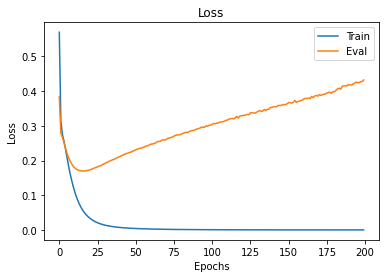

In [18]:
# [8, 9, 22, 35]
mod = MLP_model()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 200
lr = 3e-4
batch_size = 128
norm = None

hist = train_model(mod, _train, _test, device, norm,
                lr=lr, epochs=epochs, batch_size=batch_size)

plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(hist['train_loss'], label='Train')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(hist['eval_loss'], label='Eval')
plt.legend();

### Embedding

In [163]:
class dataset_(Dataset):
    
    def __init__(self, X, y, max_len=1024):
        super(dataset_, self).__init__()
        pad = [i[:max_len] + [0]*(max_len-len(i[:max_len])) for i in X]
        self.X = torch.tensor(pad, dtype=torch.int32)
        self.y = torch.Tensor(np.array(list(y)))
        
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
    def __len__(self):
        return len(self.X)
    
    
train_ = dataset_(tk_idx_train, y_train)
test_ = dataset_(tk_idx_test, y_test)

In [164]:
class Att(nn.Module):
    
    def __init__(self, dim_emb=256):
        super(Att, self).__init__()
        self.Wq = nn.Linear(dim_emb, 1, bias=False)
        self.Wk = nn.Linear(dim_emb, dim_emb, bias=False)
        self.Wv = nn.Linear(dim_emb, dim_emb, bias=False)

    def forward(self, x):
        K = self.Wk(x) 
        V = self.Wv(x)
        temp = self.Wq(K) 
        score = temp.transpose(-2, -1) / math.sqrt(K.size(-1)) ## (50, 1200)
        return torch.matmul(nn.Softmax(dim=-1)(score), V)


class final_model(nn.Module):
    
    def __init__(self, voc_size=len(voc)+1, dim_emb=256):
        super(final_model, self).__init__()
        self.net = nn.Sequential(
            nn.Embedding(voc_size, dim_emb, padding_idx=0),
            nn.Dropout(0.5),
            Att(dim_emb),  ## (50, dim_emb)
            nn.Linear(dim_emb, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid())
            
    def forward(self, x):
        return self.net(x)

In [165]:
def train_model(model, train_dataset, eval_dataset, device, norm=0.5,
                lr=0.0005, epochs=50, batch_size=256):
    
    history = {'train_loss': [], 'eval_loss': [], 'train_acc': [], 'eval_acc': []}
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    eval_loader = DataLoader(eval_dataset, batch_size=batch_size)

    model = model.to(device)
    
    if norm:
        Loss = nn.BCELoss(weight=train_.y.sum(axis=0)**-norm).to(device)

    else:
        Loss = nn.BCELoss().to(device)
        
    op = torch.optim.Adam(model.parameters(), lr=lr)
    
    print('Training start!')
    start = time.time()
    
    for epoch in range(epochs):
        
        model.train()
        train_loss = 0
        eval_loss = 0
        train_acc = 0
        eval_acc = 0
        pred = []
        real = []
        
        for X, y in train_loader:
            X = X.to(device)
            y = y.to(device)
            out = model(X).view(-1)
            loss = Loss(out, y)
            acc = (np.round(out.cpu().detach()) == y.cpu()).float().mean().item()
            
            
            op.zero_grad()
            loss.backward()
            op.step()
            
            train_loss += loss
            train_acc += acc
            
        model.eval()
        with torch.no_grad():
            for X, y in eval_loader:
                X = X.to(device)
                y = y.to(device)
                out = model(X).view(-1)
                loss = Loss(out, y)
                acc = (np.round(out.cpu().detach()) == y.cpu()).float().mean().item()

                eval_loss += loss
                eval_acc += acc
                pred.append(out.cpu())
                real.append(y.cpu())
                
        train_loss = (train_loss/len(train_loader)).item()
        eval_loss = (eval_loss/len(eval_loader)).item() 
        train_acc = train_acc/len(train_loader)
        eval_acc = eval_acc/len(eval_loader) 
        
        history['train_loss'].append(train_loss)
        history['eval_loss'].append(eval_loss)  
        history['train_acc'].append(train_acc)
        history['eval_acc'].append(eval_acc)  
        
        if not (epoch+1)%50:
            res = torch.cat(pred)
            tru = torch.cat(real)
            print(f'\nepoch {epoch+1}:\n')
            print(f"Accuracy: {np.mean(history['eval_acc'][-5:])}")
            print(classification_report(tru.view(-1), np.round(res).view(-1)))
            print(f'\nSpent time: {time.time()-start} seconds')
            
        
    print('Training complete!')
    
    
    return history

Training start!

epoch 50:

Accuracy: 0.9335321968793868
              precision    recall  f1-score   support

         0.0       0.95      0.97      0.96      2135
         1.0       0.79      0.67      0.73       330

    accuracy                           0.93      2465
   macro avg       0.87      0.82      0.84      2465
weighted avg       0.93      0.93      0.93      2465


Spent time: 68.80704665184021 seconds

epoch 100:

Accuracy: 0.9354071968793869
              precision    recall  f1-score   support

         0.0       0.95      0.97      0.96      2135
         1.0       0.79      0.70      0.74       330

    accuracy                           0.94      2465
   macro avg       0.87      0.84      0.85      2465
weighted avg       0.93      0.94      0.93      2465


Spent time: 137.55657744407654 seconds

epoch 150:

Accuracy: 0.9333759468793869
              precision    recall  f1-score   support

         0.0       0.95      0.97      0.96      2135
         1.0     

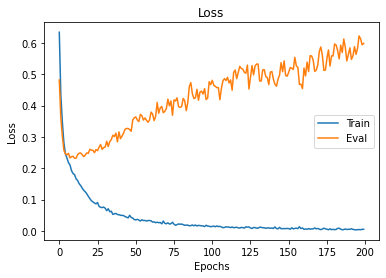

In [166]:
## 3-layer ReLU
mod = final_model()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 200
lr = 3e-4 
batch_size = 128
norm = None
hist = train_model(mod, train_, test_, device, norm,
                lr=lr, epochs=epochs, batch_size=batch_size)

plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(hist['train_loss'], label='Train')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(hist['eval_loss'], label='Eval')
plt.legend();

Training start!

epoch 50:

Accuracy: 0.933044508099556
              precision    recall  f1-score   support

         0.0       0.95      0.97      0.96      2135
         1.0       0.79      0.65      0.72       330

    accuracy                           0.93      2465
   macro avg       0.87      0.81      0.84      2465
weighted avg       0.93      0.93      0.93      2465


Spent time: 39.97839951515198 seconds
Training complete!


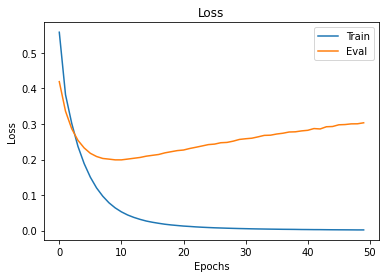

In [167]:
## 1-layer ReLU TFIDF
mod = MLP_model()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 50
lr = 3e-4 
batch_size = 128
norm = None
hist = train_model(mod, _train, _test, device, norm,
                lr=lr, epochs=epochs, batch_size=batch_size)

plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(hist['train_loss'], label='Train')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(hist['eval_loss'], label='Eval')
plt.legend();